# BOAR with SIMsalabim
Version 1.0.0
(c) Vincent M. Le Corre, Larry Lueer, i-MEET 2021-2023

This notebook is made to use BOAR in combination with drift-diffusion modeling to fit of 'fake' JV curves.  
To perform the drift-diffusion simulation in the background we use the open-source program [SIMsalabim](https://github.com/kostergroup/SIMsalabim), for more information about SIMsalabim please check the [GitHub repository](https://github.com/kostergroup/SIMsalabim)  
Make sure you have SIMsalabim installed before running this Notebook.  
Here we are fitting some 'fake' data that are generated by the drift-diffusion model.

In [1]:
# Activate matplotlib widgets
# %matplotlib inline
# comment the next line if you are on the jupyterhub server
# %matplotlib widget 
# %matplotlib notebook

# Import libraries
import sys,os
from numpy.random import default_rng
import warnings
warnings.filterwarnings('ignore') # comment this out to see warnings

# Import boar package
sys.path.append(os.path.abspath('../')) # add directory containing boar package to path
from boar import *


In [2]:
# Define path to SIMsalabim
curr_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(curr_dir, '..')) # path to the parent directory
path2simu = os.path.join(parent_dir, 'SIMsalabim','SimSS') # path to the SIMsalabim directory
# Directory where the results are stored
res_dir = os.path.join(curr_dir,'temp') # absolute path to the results directory (note that this will be delete in the last cell of this notebook)
dev_par_file = os.path.join(parent_dir,'Example_Data','Data_test','device_parameters_fake_OPV.txt') # absolute path to the device parameter file (here we use a fake OPV device for illustration purposes)

### Define the free parameters to be optimized

In [3]:
# define Fitparameters
True_params = {'kdirect':5e-18,'mun_0':2e-8,'mup_0':8e-8,'Nc':5e26,'Gehp':1.28e28,'W_L':0}#,'Rseries':3e-4,'Bulk_tr':1e20,'Gehp':1.28e28}
params = []

kdirect = Fitparam(name = 'kdirect', val = True_params['kdirect'] , relRange = 1.5, lims=[1e-18,1e-16],range_type='log',optim_type='log',display_name='k$_{2}$',unit='m$^{3}$ s$^{-1}$') 
params.append(kdirect)

mun_0 = Fitparam(name = 'mun_0', val = True_params['mun_0'] , relRange = 1.5, lims=[1e-8,1e-7],range_type='log',optim_type='log',display_name='$\mu_n$',unit='m$^{2}$ V$^{-1}$ s$^{-1}$')
params.append(mun_0)

mup_0 = Fitparam(name = 'mup_0', val = True_params['mup_0'] , relRange = 1.5, lims=[1e-8,1e-7],range_type='log',optim_type='log',display_name='$\mu_p$',unit='m$^{2}$ V$^{-1}$ s$^{-1}$')
params.append(mup_0)

params_true = copy.deepcopy(params)


### Check the structure of the device for SIMsalabim
Here we check the structure of the device for SIMsalabim and you can adjust the parameters if needed.

For example, if you want to change the thickness of the active layer (AL) you can do this by changing the value of the variable `L` in the cell below.
To do so you need to update the value of the variable ParFileDic['L'] and set MakeUpdate to True.

By convention LTL is the ETL and RTL is the HTL.\
Note that L is the **total** thickness of the ETL, HTL and active layer, so if you want to change the thickness of the active layer you need to subtract the thickness of the ETL and HTL from the total thickness. 
Such that:

$L_{AL} = L - L_{LTL} - L_{RTL}$

To check the name of the parameters in SIMsalabim please refer to the [SIMsalabim documentation](https://github.com/kostergroup/SIMsalabim).

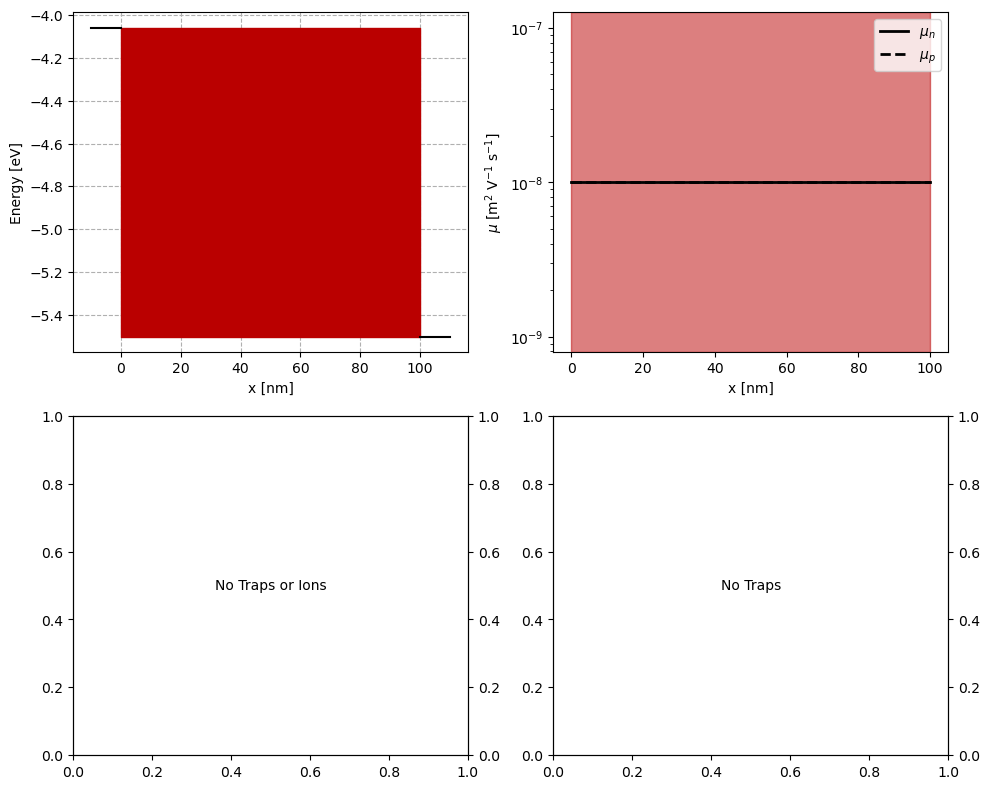

In [4]:
# Vizualize the stack defined for the simulation
check_SIMsalabim_input = True
# from boar.SIMsalabim_utils.MakeDevParFile import *
# from boar.SIMsalabim_utils.GetInputPar import *

if check_SIMsalabim_input:
    from boar.SIMsalabim_utils.PlotInputPar import *
    # Load Device parameters file and update parameters
    ParFileDic = ReadParameterFile(dev_par_file) # read the parameters from the file

    # Change parameters in the dictionary
    ParFileDic['L'] =  100e-9
   
    MakeUpdate = False # set to True to update the parameters in the file
    if MakeUpdate:
        UpdateDevParFile(ParFileDic, path2simu) # update the parameters in the file

    # Visualize the parameters
    fig, axs = plt.subplots(2,2,figsize = (10,8))
    plot_input_nrj_diag(ParFileDic,ax=axs[0, 0])
    plot_input_mob(ParFileDic,ax=axs[0, 1])
    plot_input_dens(ParFileDic,ax=axs[1, 0])
    plot_input_SRH_lifetime(ParFileDic,ax=axs[1, 1],y_unit='ns',y2_unit='cm')
    plt.tight_layout()
    plt.show()

### Prepare fake data for fitting
In the next block we create some fake data with some random noise and plot it.

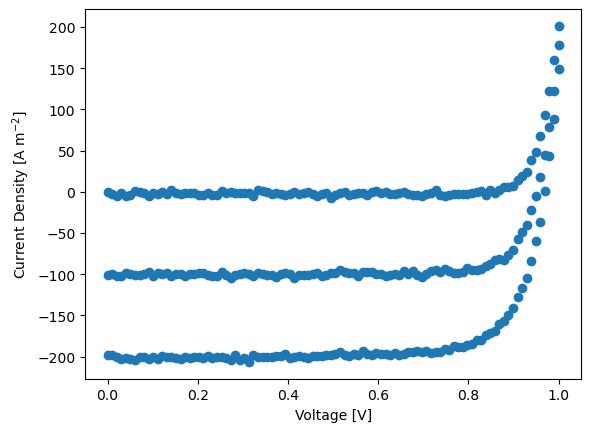

In [5]:
# # create some fake data
Nc = 1 # number of fake datasets
V = np.linspace(0,1,100) # voltage
Gfrac = np.asarray([0.01,0.5,1]) # Gfrac, i.e. light intensity

X_dimensions = ['Vext','Gfrac'] # dimensions of the X array
X = np.array([[x,y] for y in Gfrac for x in V ] ) # X array
Xplot = Gfrac # X array for plotting

# Generate the fake data to fit
degradation_run = True
True_paramsList = []

# define the degradation of kdirect
kvals = np.geomspace(5e-18,5e-17,Nc) # simulate degradation of kdirect

dda = Drift_diffusion_agent(path2simu=path2simu) # instantiate the agent

ys = []
True_vals = []
True_FOMs = []
for kval in kvals:
    kdirect.val = kval
    True_paramsList.append({'kdirect':kval})
    True_params['kdirect'] = kval
    # store the true values for plotting later
    True_vals.append(True_params.copy())

    y = dda.DriftDiffusion_relative(X,params,X_dimensions=X_dimensions, max_jobs=3,dev_par_fname=dev_par_file) # simulate the data
    rng = default_rng()#
    noise = rng.standard_normal(y.shape) * 1.9
    #noise = noise * X[:,1] # try this: higher T - higher noise  
    y+=noise # add some noise
    ys.append(y)
  
    plt.plot(X[:,0],y,'o')
plt.xlabel('Voltage [V]')
plt.ylabel('Current Density [A m$^{-2}$]')
# save params list to be modified later to store true values
params_true = copy.deepcopy(params)



### Start the optimization

Scaling runs for target 0:   0%|          | 0/1 [00:00<?, ?it/s]

Starting with initial points


Initial points:   0%|          | 0/34 [00:00<?, ?it/s]

Initial points done in 1401.74 s
Starting with BO


BO runs: 0it [00:00, ?it/s]

BO done in 0.01 s
Ground truth minimum at: [-17.349697319002356, -7.116984080529656, -7.7333124911863855] with function value: 0.10688843537085979
Minimum of surrogate function: [-17.349697319002356, -7.116984080529656, -7.7333124911863855] with function value 0.1079889439631998
Sampling for posterior distribution done in  0.11069393157958984 s


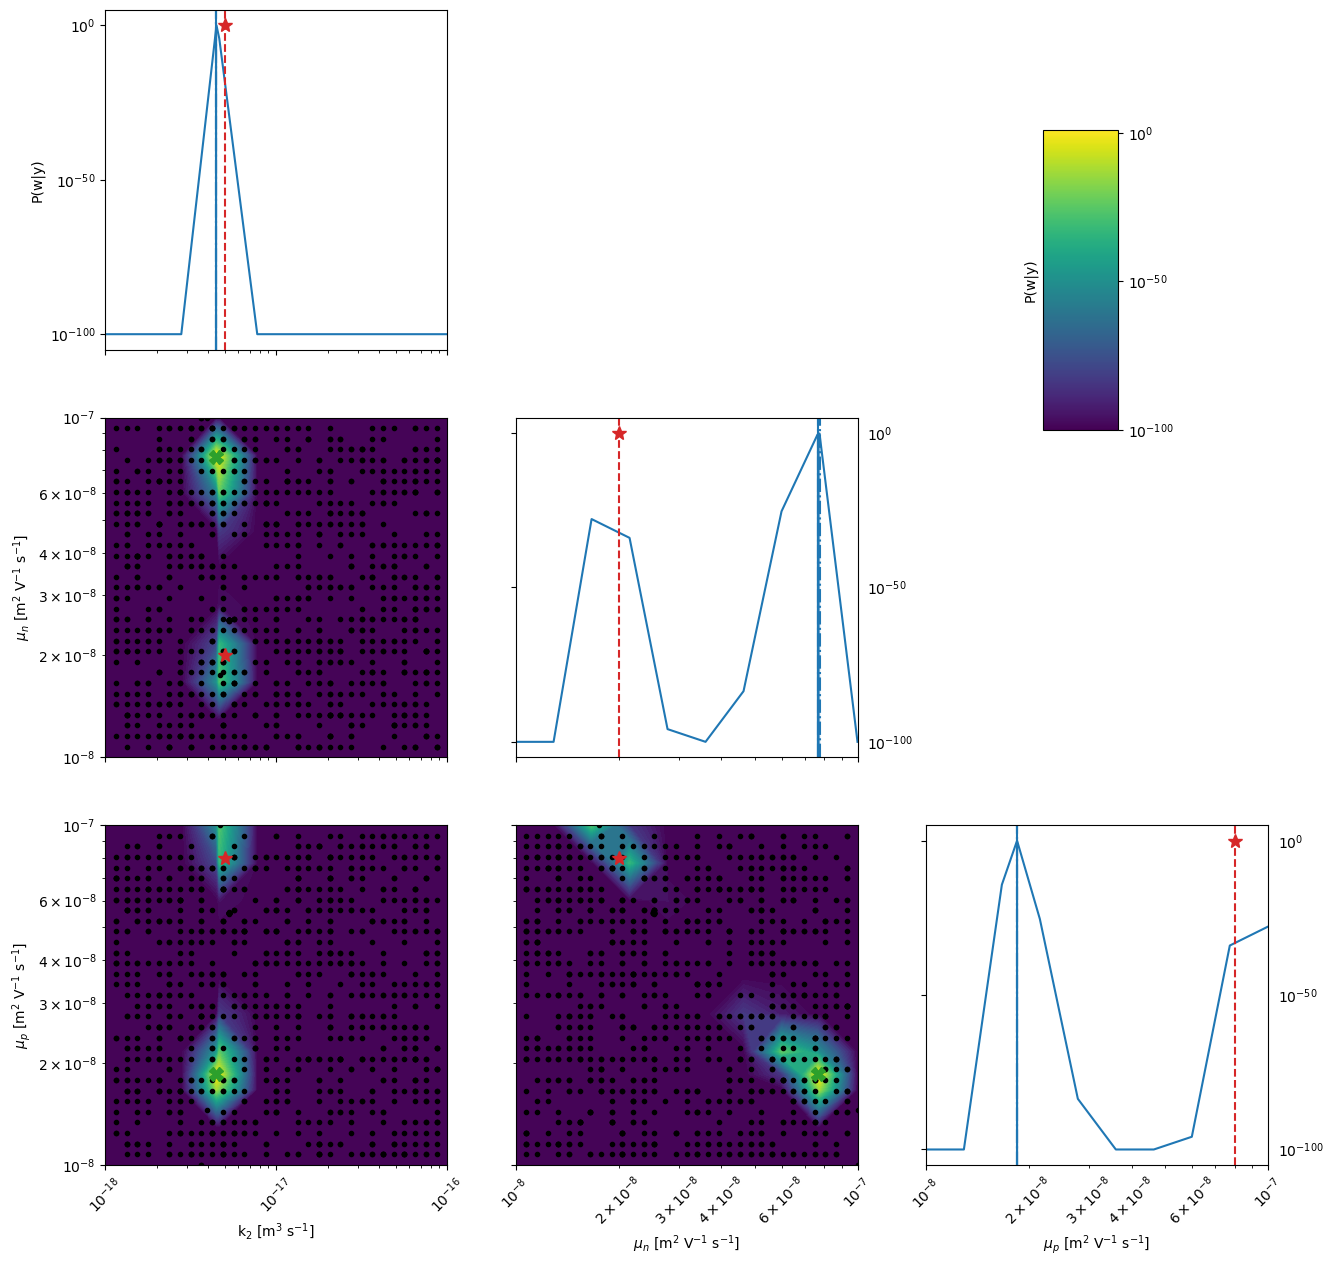

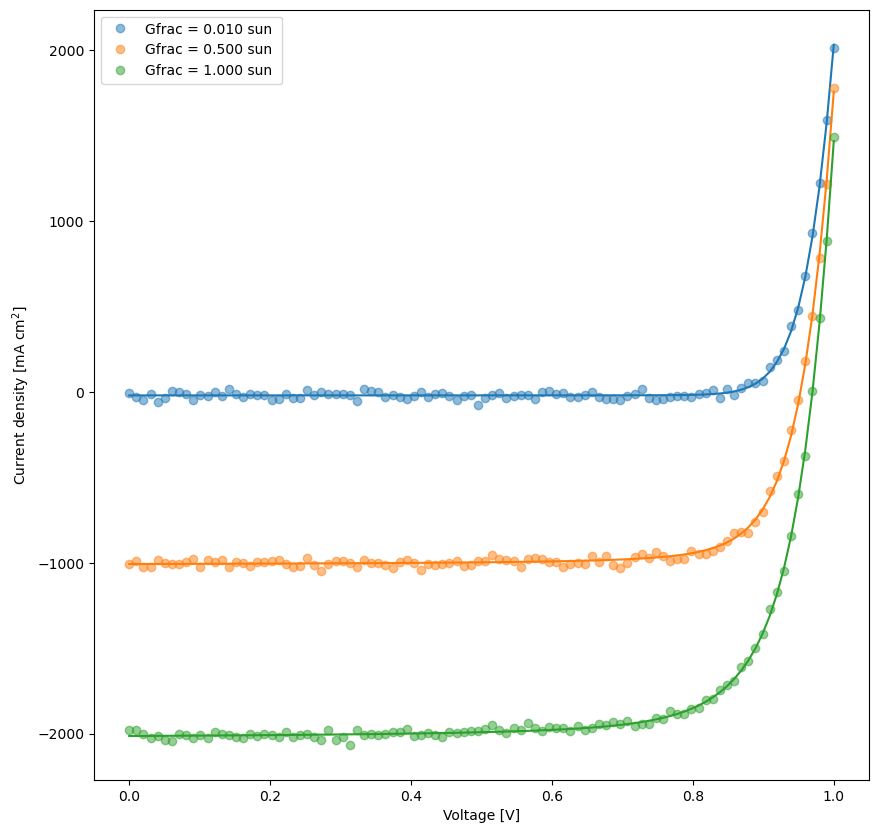

In [6]:
# Fit the datasets one by one
pf = [] # list to store the fit results
mo = MultiObjectiveOptimizer(params=params,res_dir=res_dir) # instantiate the optimizer

n_jobs = 4 
n_jobs_init = 25
n_yscale=2 
n_initial_points = 60 
n_BO = 60 
n_BO_warmstart = 60 

for ii,y in enumerate(ys):
    target = {'model':partial(dda.DriftDiffusion_relative,X_dimensions=X_dimensions,max_jobs=3,dev_par_fname=dev_par_file),'target_name':'JV','data':{'X':X,'y':y,
                'X_dimensions':['Vext','Gfrac'],'X_units':['V','sun'],'y_dimension':'Current density','y_unit':r'$A/m²$'},'weight':1,'target_weight':1}
    mo.targets = [target]
    mo.params = params
    mo.warmstart = 'collect_init' if ii==0 else 'recall'
    # mo.warmstart = 'None'
    mo.SaveOldXY2file = os.path.join(res_dir,'old_XY.json') # path to the file where old points are saved
    mo.Path2OldXY = os.path.join(res_dir,'old_XY.json') # path to the file where old points are saved
   
    kwargs = {'check_improvement':'relax','max_loop_no_improvement':10,'xtol':1e-3,'ftol':1e-3,'initial_point_generator':'grid'}
    kwargs_posterior = {'Nres':10,'gaussfilt':3,'logscale':True,'vmin':1e-100,'zoom':0,'min_prob':1e-40,'clear_axis':False,'True_values':True_vals[ii],'show_points':True,'savefig':False,'figname':'param_posterior'+str(ii),'full_grid':True,'randomize':False}
    kwargs_plot_obj = {'zscale':'linear'}

    r = mo.optimize_sko_parallel(n_jobs=n_jobs,n_yscale=n_yscale, n_BO=n_BO, n_initial_points = n_initial_points,n_BO_warmstart=n_BO_warmstart,n_jobs_init=n_jobs_init,kwargs=kwargs,verbose=False,loss='linear',threshold=1000,base_estimator = 'GP',show_objective_func=False,show_posterior=True,kwargs_posterior = kwargs_posterior,kwargs_plot_obj=kwargs_plot_obj,)
    pf.append(deepcopy(mo.params)) # collects optimized fitparameters
    rrr = r['r'] # the results dict of the last optimizer.tell()


    #get true parameters and make a params object
    for param in params_true:
        if param.name in True_paramsList[ii]:
            param.val = True_paramsList[ii][param.name]

    # plot the fit results
    fit_results = []
    kwargs_plot_res = {'x_scaling':1,'xaxis_label':'Voltage [V]','xscale_type':'linear','y_scaling':10,'yaxis_label':'Current density [mA cm$^2$]','yscale_type':'linear','norm_data':False,'delog':False,'figsize':(10,10),'savefig':False,'figname':'JV_fits_' + str(ii),'figdir':'temp'}

    for num,t in enumerate(mo.targets):
        kwargs_plot_res['figname'] = os.path.join(res_dir,t['target_name']+f'_fit_{num}')
        dda.plot_fit_res(t,mo.params,'Vext',xlim=[],ylim=[],kwargs=kwargs_plot_res)

        X = t['data']['X']
        y = t['data']['y']
        X_dimensions = t['data']['X_dimensions']
        yfit = t['model'](X,params,X_dimensions=X_dimensions) # get the best fits

        data = np.concatenate((X, y.reshape(len(y),1), yfit.reshape(len(yfit),1)), axis=1)
        fit_results.append(data)

    # prepare the data for saving
    param_dict = dda.get_param_dict(mo.params) # get fitparameters (and fixed ones) as dict
    pout = [[f'{v:.3E}' if isinstance(v,float) else v for _,v in pp.items()] for pp in param_dict] # convert to list of lists

    save_output = False
    if save_output:
        # produce output excel file with data, fitparameters and FOMs
        fn_xlsx = 'fits_results.xlsx'
        namecols = X_dimensions + ['Jexp','Jfit']
        # delete old file if it exists
        if os.path.exists(os.path.join(res_dir,fn_xlsx)):
            os.remove(os.path.join(res_dir,fn_xlsx))

        with pd.ExcelWriter(os.path.join(res_dir,fn_xlsx), mode='w') as writer:
            for i,t in enumerate(mo.targets):
                if 'target_name' in t.keys():
                    tname = t['target_name']
                else: 
                    tname = 'data'
                namecols = X_dimensions + [tname+'_exp',tname+'_fit']
                df = pd.DataFrame(fit_results[i],columns=namecols)
                df.to_excel(writer, sheet_name = tname+f'_{i}')
            
            df = pd.DataFrame(pout,columns=[k for k in param_dict[0].keys()])
            df.to_excel(writer, sheet_name = f'params')
        


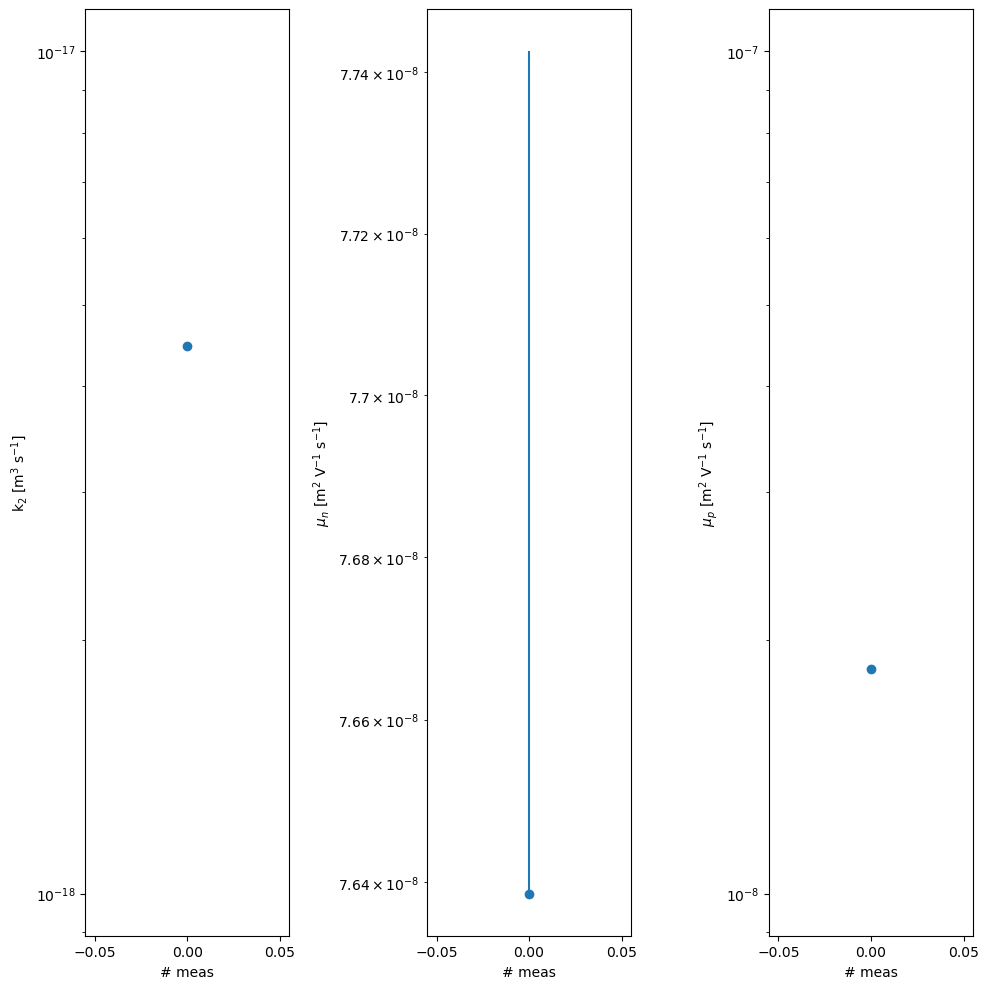

In [7]:
# plot the parameters evolution
param_plot = dda.plot_params(pf,kwargs={'savefig':False,'figname':'plot_param','figdir':'temp','nrows':1,'ncols':3,'figsize':(10,10)})


In [8]:
# Clean output files from simulation folders
from boar.SIMsalabim_utils.CleanFolder import *

Do_Cleaning = True # Careful, this will delete all files in the folder
if Do_Cleaning:
    clean_up_output('tj',path2simu)
    clean_up_output('tVG',path2simu)
    clean_up_output('JV',path2simu)
    clean_up_output('Var',path2simu)
    clean_up_output('scPars',path2simu)
    clean_up_output('Str4Parallel',path2simu)
    clean_up_output('log',path2simu)
    # os.remove(mo.path2oldxy) # remove the old_xy.json file if it exists
    # delete warmstart folder if it exists
    if os.path.exists(os.path.join(os.getcwd(),'warmstart/')):
        shutil.rmtree(os.path.join(os.getcwd(),'warmstart/'))
    # delete temp folder if it exists
    if os.path.exists(res_dir):
        shutil.rmtree(res_dir)

